## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset

In [2]:

df = pd.read_csv('Datasets/stack_dataset_long.csv',index_col=0,parse_dates=True)
len(df)

1032

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

1032

## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

In [4]:
from datetime import datetime, timedelta
t = np.arange(np.datetime64('2022-06-01'), np.datetime64('2022-07-14'),step=7)
t

array(['2022-06-01', '2022-06-08', '2022-06-15', '2022-06-22',
       '2022-06-29', '2022-07-06', '2022-07-13'], dtype='datetime64[D]')

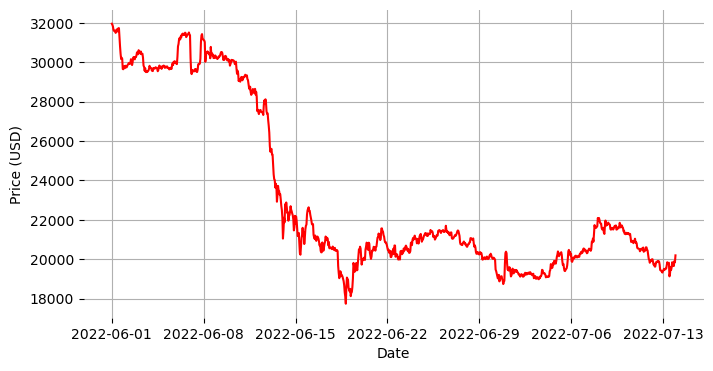

In [7]:
fig, ax = plt.subplots()
ax.plot(df['price'],c='red')
ax.grid()
ax.set_xticks(t)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')

plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
#plt.savefig('../Write-Up/CHAPTER_5/bitcoin_price_python.png', format='png',dpi=600)

plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [9]:
# Extract values from the source .csv file
y = df['price'].values.astype(float)
X = df[['tweet_count','tweet_gt','POS','NEG','NEU','price']].values.astype(float)

# Define a test size
test_size = 24

# Create train and test sets
train_set = X[:-test_size]
test_set = X[-test_size:]

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [11]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 6))

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [12]:
# Convert train_norm from an array to a tensor
#train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm = torch.FloatTensor(train_norm)

# Define a window size
window_size = 24

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1][0]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

984

In [13]:
# Display the first seq/label tuple in the train data
len(train_data)

984

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [14]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=6,hidden_size=50,output_size=6):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [15]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

model

LSTMnetwork(
  (lstm): LSTM(6, 50)
  (linear): Linear(in_features=50, out_features=6, bias=True)
)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1200
 10000
   200
   200
   300
     6
______
 11906


## Train the model

In [17]:
epochs = 300

loss_array = []


import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    loss_array = np.append(loss_array,loss.item())

    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.27568269
Epoch:  2 Loss: 0.23078579
Epoch:  3 Loss: 0.17170961
Epoch:  4 Loss: 0.09195790
Epoch:  5 Loss: 0.05902129
Epoch:  6 Loss: 0.05191975
Epoch:  7 Loss: 0.04826482
Epoch:  8 Loss: 0.04593277
Epoch:  9 Loss: 0.04469991
Epoch: 10 Loss: 0.04426825
Epoch: 11 Loss: 0.04408953
Epoch: 12 Loss: 0.04386796
Epoch: 13 Loss: 0.04355413
Epoch: 14 Loss: 0.04318561
Epoch: 15 Loss: 0.04277657
Epoch: 16 Loss: 0.04230431
Epoch: 17 Loss: 0.04174961
Epoch: 18 Loss: 0.04111055
Epoch: 19 Loss: 0.04039660
Epoch: 20 Loss: 0.03962323
Epoch: 21 Loss: 0.03881097
Epoch: 22 Loss: 0.03798502
Epoch: 23 Loss: 0.03717225
Epoch: 24 Loss: 0.03639827
Epoch: 25 Loss: 0.03568331
Epoch: 26 Loss: 0.03504037
Epoch: 27 Loss: 0.03447479
Epoch: 28 Loss: 0.03398543
Epoch: 29 Loss: 0.03356653
Epoch: 30 Loss: 0.03321036
Epoch: 31 Loss: 0.03290777
Epoch: 32 Loss: 0.03265012
Epoch: 33 Loss: 0.03242925
Epoch: 34 Loss: 0.03223806
Epoch: 35 Loss: 0.03207029
Epoch: 36 Loss: 0.03192065
Epoch: 37 Loss: 0.03178434
E

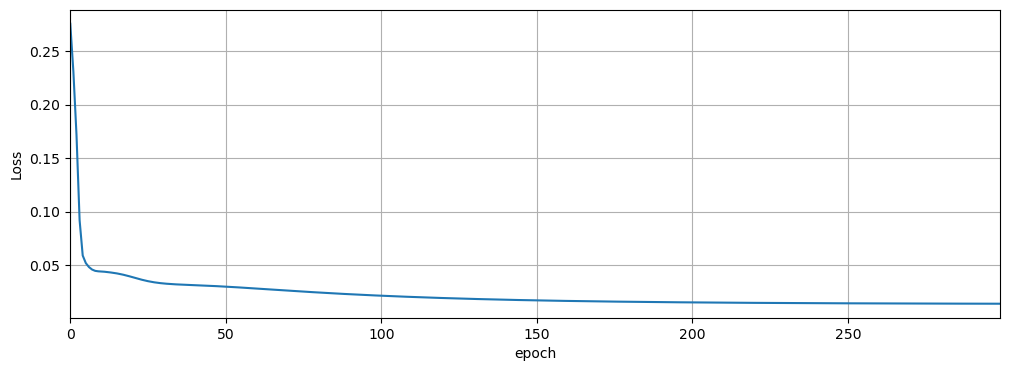

In [18]:
#Plotting the loss over the epoch

plt.figure(figsize=(12,4))
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(loss_array)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.show()

## Run predictions and compare to known test set

In [19]:
future = 24
preds = train_norm[-window_size:].tolist()
len(preds)

24

In [20]:
future = 24

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).numpy())

/var/folders/zm/bf3yd8d526x62v9mglx0hpqw0000gn/T/ipykernel_29711/2553314220.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/torch/csrc/utils/tensor_new.cpp:233.)
  seq = torch.FloatTensor(preds[-window_size:])


In [21]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[array([-0.8818811 ,  0.29293334, -0.45034197, -0.08189543,  0.096899  ,
        -0.7483436 ], dtype=float32),
 array([-0.89170206,  0.28234813, -0.41899705, -0.14550462,  0.1174974 ,
        -0.74517465], dtype=float32),
 array([-0.8843821 ,  0.2620739 , -0.39934617, -0.20537776,  0.1449776 ,
        -0.74348897], dtype=float32),
 array([-0.86100537,  0.23819688, -0.38669473, -0.26006293,  0.1761612 ,
        -0.740549  ], dtype=float32),
 array([-0.82444763,  0.21434538, -0.379598  , -0.30688643,  0.20761241,
        -0.73729753], dtype=float32),
 array([-0.77793807,  0.19334748, -0.37621137, -0.34407642,  0.23641829,
        -0.7340195 ], dtype=float32),
 array([-0.72520185,  0.17728315, -0.37526116, -0.37117806,  0.26029617,
        -0.7303976 ], dtype=float32),
 array([-0.6698279 ,  0.16729046, -0.37543884, -0.38834655,  0.27741265,
        -0.72601956], dtype=float32),
 array([-0.61573774,  0.16388299, -0.37610823, -0.39647487,  0.28700972,
        -0.7205245 ], dtype=float32),
 

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [22]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 6))
true_predictions

array([[5.98157617e+03, 7.06567307e+01, 2.07078651e-01, 1.47790968e-01,
        6.43636286e-01, 1.95324219e+04],
       [5.85938916e+03, 7.02174454e+01, 2.10565597e-01, 1.42646313e-01,
        6.45612299e-01, 1.95549316e+04],
       [5.95045996e+03, 6.93760681e+01, 2.12751642e-01, 1.37803838e-01,
        6.48248434e-01, 1.95669043e+04],
       [6.24130176e+03, 6.83851700e+01, 2.14159057e-01, 1.33380949e-01,
        6.51239872e-01, 1.95877871e+04],
       [6.69613477e+03, 6.73953323e+01, 2.14948535e-01, 1.29593909e-01,
        6.54256940e-01, 1.96108828e+04],
       [7.27478369e+03, 6.65239258e+01, 2.15325266e-01, 1.26586020e-01,
        6.57020271e-01, 1.96341680e+04],
       [7.93090137e+03, 6.58572540e+01, 2.15430975e-01, 1.24394059e-01,
        6.59310877e-01, 1.96598926e+04],
       [8.61983691e+03, 6.54425507e+01, 2.15411201e-01, 1.23005487e-01,
        6.60952806e-01, 1.96909902e+04],
       [9.29279883e+03, 6.53011398e+01, 2.15336740e-01, 1.22348078e-01,
        6.61873460e-01, 

In [23]:
df['price'][-24:]

date
2022-07-13 00:00:00    19418.433594
2022-07-13 01:00:00    19432.242188
2022-07-13 02:00:00    19514.521484
2022-07-13 03:00:00    19476.722656
2022-07-13 04:00:00    19483.041016
2022-07-13 05:00:00    19523.578125
2022-07-13 06:00:00    19529.691406
2022-07-13 07:00:00    19704.132812
2022-07-13 08:00:00    19849.804688
2022-07-13 09:00:00    19793.900391
2022-07-13 10:00:00    19770.763672
2022-07-13 11:00:00    19821.853516
2022-07-13 12:00:00    19134.027344
2022-07-13 13:00:00    19278.751953
2022-07-13 14:00:00    19590.097656
2022-07-13 15:00:00    19463.070312
2022-07-13 16:00:00    19582.972656
2022-07-13 17:00:00    19849.949219
2022-07-13 18:00:00    19807.251953
2022-07-13 19:00:00    19661.580078
2022-07-13 20:00:00    19659.623047
2022-07-13 21:00:00    19911.724609
2022-07-13 22:00:00    19845.537109
2022-07-13 23:00:00    20198.314453
Name: price, dtype: float64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [24]:
import datetime
from datetime import timedelta
# Remember that the stop date has to be later than the last predicted value.
#x = np.arange('2018-02-01', '2019-02-01',dtype='datetime64[M]').astype('datetime64[D]')
x = pd.date_range(start='2022-07-13', end='2022-07-14',freq='H')[:-1]

In [25]:
len(true_predictions)

24

In [26]:
predicitons_array = []
for i in range(len(true_predictions)):
    print(i, true_predictions[i][5])
    predicitons_array = np.append(predicitons_array,true_predictions[i][5])

0 19532.422
1 19554.932
2 19566.904
3 19587.787
4 19610.883
5 19634.168
6 19659.893
7 19690.99
8 19730.023
9 19777.197
10 19830.412
11 19886.072
12 19941.834
13 19995.64
14 20046.113
15 20092.5
16 20135.43
17 20173.75
18 20207.81
19 20237.906
20 20263.945
21 20287.22
22 20307.74
23 20326.072


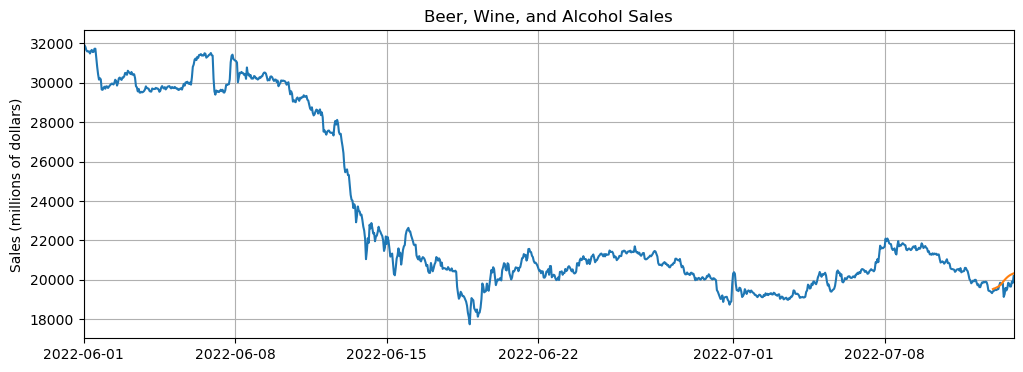

In [27]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['price'])
plt.plot(x,predicitons_array)
plt.show()

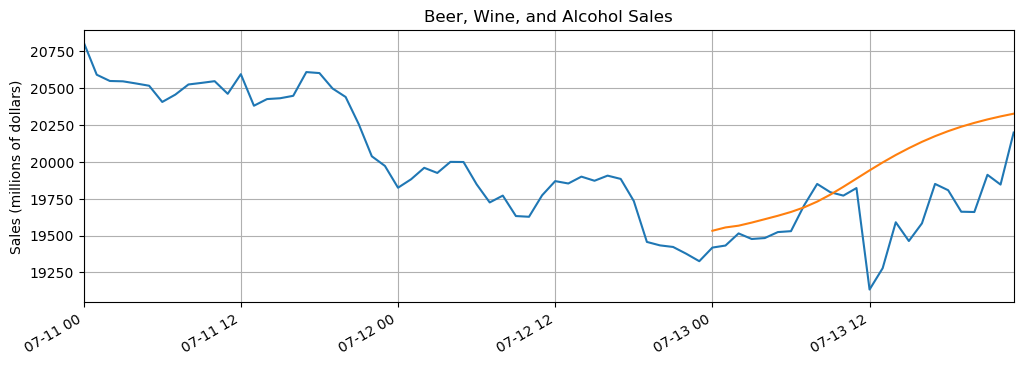

In [28]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['price']['2022-07-11':])
plt.plot(x,predicitons_array)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [ ]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

## Predict future values, plot the result

In [ ]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

## Great job!

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [ ]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [ ]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

In [ ]:
train_data[0]

In [ ]:
help(create_train_data)